<a href="https://colab.research.google.com/github/Hamza11222/resnet50_feture_extraction_for_insects/blob/main/resnet50_feture_extraction_for_insects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

import numpy as np
import pandas as pd 
import os
print(os.listdir("/content/gdrive/My Drive/pest"))

['test', 'train']


Import libraries

In [ ]:
import torch
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import numpy as np
from matplotlib import pyplot as plt

# Prepare Data

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_dir = "/content/gdrive/My Drive/pest"

train_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.RandomResizedCrop(150),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_transform = transforms.Compose([
                                transforms.Resize(150),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

train_data  = datasets.ImageFolder(data_dir + '/train', train_transform)
test_data = datasets.ImageFolder(data_dir + '/test', test_transform)

Load Class and ids

In [ ]:
classes = train_data.classes
class_idx = train_data.class_to_idx
class_idx

{'aphids': 0,
 'armyworm': 1,
 'beetle': 2,
 'bollworm': 3,
 'grasshopper': 4,
 'mites': 5,
 'mosquito': 6,
 'sawfly': 7,
 'stem_borer': 8}

Prepare Data loader

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=100,
                                           shuffle=True,
                                           num_workers=1)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=1)

print(len(train_loader))

27


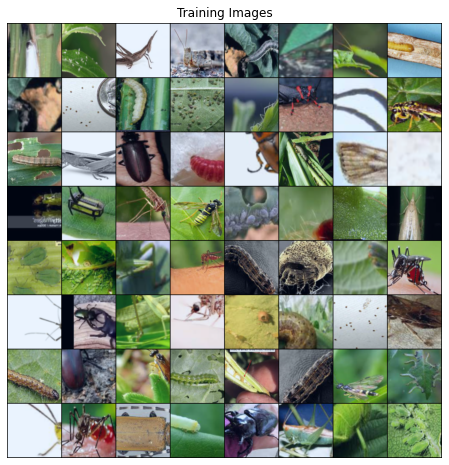

In [ ]:
import torchvision.utils as vutils
workers = 2
batch_size = 128
image_size = 150
nc = 3
nz = 10
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
real_batch = next(iter(train_loader ))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Check shape of Image

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
import torch.optim as optim
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.
fake_label = 0.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output[0:100], label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/27]	Loss_D: 1.4098	Loss_G: 6.2692	D(x): 0.4979	D(G(z)): 0.4560 / 0.0051
[1/5][0/27]	Loss_D: 0.2301	Loss_G: 7.1896	D(x): 0.8621	D(G(z)): 0.0739 / 0.0020
[2/5][0/27]	Loss_D: 0.0823	Loss_G: 5.9035	D(x): 0.9275	D(G(z)): 0.0285 / 0.0041
[3/5][0/27]	Loss_D: 0.0758	Loss_G: 5.8465	D(x): 0.9606	D(G(z)): 0.0233 / 0.0044
[4/5][0/27]	Loss_D: 0.0729	Loss_G: 7.3839	D(x): 0.9697	D(G(z)): 0.0201 / 0.0008


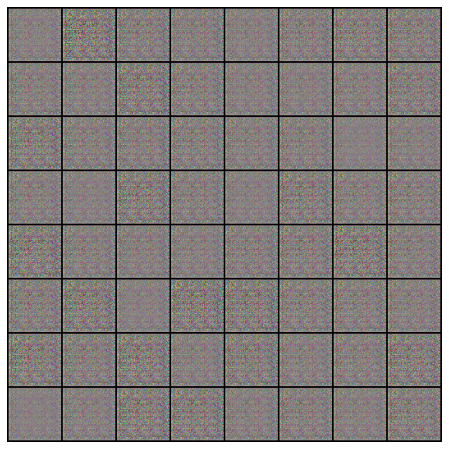

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

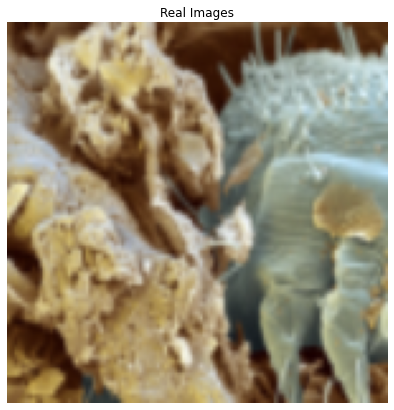

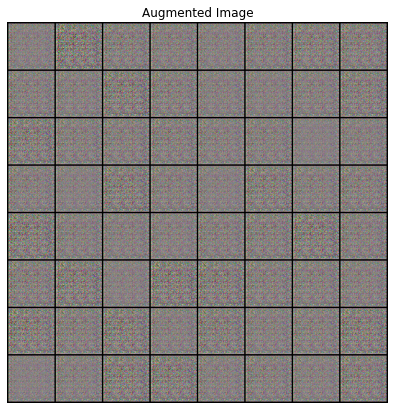

In [ ]:
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1], padding=5, normalize=True).cpu(),(1,2,0)))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Augmented Image")
plt.imshow( img_list[1].permute(1, 2, 0)  )

In [ ]:
images  = next(iter(img_list))
images.shape

torch.Size([3, 530, 530])

In [ ]:
data_iter = iter(test_loader)
images, labels = data_iter.next()

# Visualize 
data from data loder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


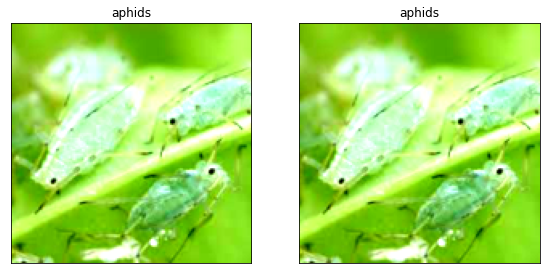

In [ ]:
# visualize data
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(test_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

In [ ]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
__all__ = ['resnet50']
model_urls = {'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth'}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model
def resnet50(value=False, progress=True, **kwargs):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


## Load ResNet50 model

In [ ]:
model = resnet50(value=True)
model.fc

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Linear(in_features=2048, out_features=1000, bias=True)

Freeze Parameters

In [ ]:
for param in model.parameters():
    param.required_grad = False

In [ ]:
import torch.optim as optim
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
  nn.Linear(in_features=1000, out_features=512),
  nn.LeakyReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=512, out_features=256),
  nn.LeakyReLU(),
  nn.Dropout(p=0.3),
  nn.Linear(in_features=256, out_features=9),
  nn.LogSoftmax(dim=1))
  
    def forward(self, x):
        x = self.fc1(x)
        return x
net = Model().cuda()

# Training

In [ ]:

n_epochs = 5
train_loss_data,valid_loss_data = [],[]
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(32))
class_total = list(0. for i in range(32))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    model.train() # prep model for training
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output1 = net(output+output)    
        loss = criterion(output1, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 
    model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        output1 = net(output+output) 
        # calculate the loss
        loss = criterion(output1, target)
        valid_loss += loss.item() 
        _, pred = torch.max(output1, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)

    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))
    print('\t\tTest Accuracy: %4d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1/5 	Training Loss: 0.015394 	Validation Loss: 0.009620
		Test Accuracy:   76% (61/80)
		Validation loss decreased (inf --> 0.009620).  Saving model ...
Epoch: 2/5 	Training Loss: 0.009798 	Validation Loss: 0.008068
		Test Accuracy:   81% (131/160)
		Validation loss decreased (0.009620 --> 0.008068).  Saving model ...
Epoch: 3/5 	Training Loss: 0.008474 	Validation Loss: 0.006474
		Test Accuracy:   84% (202/240)
		Validation loss decreased (0.008068 --> 0.006474).  Saving model ...
Epoch: 4/5 	Training Loss: 0.007460 	Validation Loss: 0.005987
		Test Accuracy:   85% (275/320)
		Validation loss decreased (0.006474 --> 0.005987).  Saving model ...
Epoch: 5/5 	Training Loss: 0.006965 	Validation Loss: 0.005176
		Test Accuracy:   86% (347/400)
		Validation loss decreased (0.005987 --> 0.005176).  Saving model ...


In [ ]:

output1 = net(output+output)    
output1    

tensor([[-2.6241, -2.3326, -1.5046, -2.3735, -2.4377, -2.1868, -1.6954, -2.6930,
         -2.7434],
        [-2.8878, -2.1544, -2.2473, -3.3615, -2.1457, -2.5094, -0.9595, -2.7226,
         -3.1977],
        [-2.1126, -2.5500, -2.3526, -1.5689, -2.3357, -1.9039, -2.7437, -2.8697,
         -2.0340],
        [-2.1157, -1.5331, -2.6423, -3.0438, -1.8642, -2.0344, -2.2788, -2.4632,
         -2.6397],
        [-2.0463, -2.6706, -2.3475, -2.2683, -1.8579, -2.0234, -2.1578, -2.0960,
         -2.5804],
        [-1.8564, -1.8101, -2.7324, -2.1519, -2.0355, -2.9707, -1.8857, -2.1008,
         -3.1505],
        [-2.0757, -1.9883, -3.0639, -2.2121, -1.4410, -2.7546, -2.3213, -2.5982,
         -2.2206],
        [-1.7833, -2.6130, -2.4761, -3.7014, -2.7162, -2.0751, -1.1773, -2.9305,
         -2.3362],
        [-2.2255, -2.5020, -2.5298, -1.9992, -1.8736, -2.3253, -1.9152, -2.5290,
         -2.1492],
        [-2.7105, -2.1570, -2.2971, -2.3761, -2.0633, -2.0997, -1.9120, -1.9884,
         -2.4065],


In [ ]:
target

tensor([1, 2, 7, 7, 4, 4, 6, 3, 5, 0, 8, 4, 8, 3, 3, 4, 1, 3, 1, 3, 2, 7, 4, 7,
        7, 5, 6, 0, 8, 4, 3, 8, 3, 4, 0, 6, 0, 2, 6, 3, 7, 0, 7, 0, 4, 2, 0, 0,
        7, 3, 3, 6, 6, 4, 5, 2, 5, 6, 1, 5, 5, 6, 2, 1, 3, 0, 8, 8, 8, 1, 2, 4,
        0, 1, 4, 5, 0, 7, 3, 0, 8, 7, 3, 0, 3, 3, 8, 3, 3, 2, 6, 2, 6, 7, 8, 2,
        1, 6, 1, 8], device='cuda:0')

## Load Saved best model

## Save Model

In [ ]:
# save model
torch.save(model.state_dict(), 'model83.pt')

## Check Overfitting

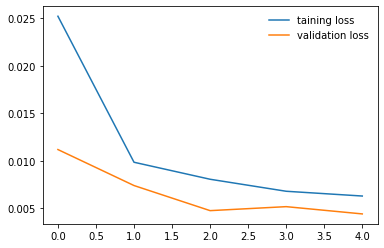

In [ ]:
# check for overfitting
plt.plot(train_loss_data, label = "taining loss")
plt.plot(valid_loss_data, label = "validation loss")
plt.legend(frameon = False)